# k-means и k-means++
Алгоритм k-means минимизирует сумму квадратов расстояний до центров кластеров: $\min_{\mu_1,\ldots,\mu_k} \sum_{i=1}^{n} \min_{j} ||x_i-\mu_j||^2$. Он чередует шаги присвоения ближайшего центра и пересчета центров как среднего. Инициализация k-means++ выбирает первый центр случайно, а следующие с вероятностью, пропорциональной квадрату расстояния до ближайшего центра, что уменьшает шанс плохой локальной минимизации.


## Используемые библиотеки
Используем `numpy`, `pandas`, `seaborn`, `matplotlib`. Из `sklearn` — `make_blobs` для генерации синтетических кластеров, `StandardScaler`, `KMeans`, `silhouette_score`.


In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [18]:
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.dpi"] = 120
PRIMARY_COLOR = "#1f77b4"
SECONDARY_COLOR = "#ff7f0e"
HEATMAP_CMAP = "coolwarm"


## Датасет: описание и частичная распечатка
Синтетический датасет из 400 точек в двумерном пространстве, сгенерированных вокруг 4 центров с `cluster_std=1.1`. Используем синтетику, чтобы знать «правильный ответ» (4 кластера) и визуально проверить результат кластеризации. Два признака позволяют строить наглядные scatter-графики.


In [19]:
X, _ = make_blobs(
    n_samples=400,
    centers=4,
    cluster_std=1.1,
    random_state=42,
)

data = pd.DataFrame(X, columns=["feature_1", "feature_2"])
print(f"Размерность: {data.shape}")
data.head()


Размерность: (400, 2)


,feature_1,feature_2
0,-10.246800,9.253797
1,-5.390917,9.918379
2,-9.108645,7.023527
3,5.712511,1.811407
4,5.267858,3.222292


## Предварительная обработка
Применяем `StandardScaler`. Это важно для k-means: алгоритм использует евклидово расстояние, и признаки с разным масштабом смещали бы центры кластеров. После стандартизации оба признака вносят одинаковый вклад в расстояния.


In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)


## Тепловая карта корреляций
При генерации через `make_blobs` два признака независимы по построению — корреляция близка к нулю. Это подтверждает, что оба признака информативны и не дублируют друг друга.


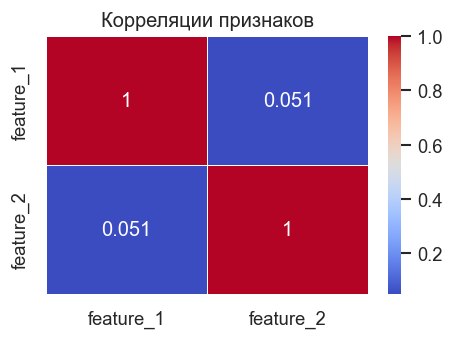

In [21]:
plt.figure(figsize=(4, 3))
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap=HEATMAP_CMAP, linewidths=0.5)
plt.title("Корреляции признаков")
plt.tight_layout()
plt.show()


## Обучение моделей
Обучаем два варианта k-means с `n_clusters=4`:
- **random** — центры инициализируются случайно из данных, `n_init=10` перезапусков;
- **k-means++** — умная инициализация, снижающая риск попасть в плохой локальный минимум.

Оба запускаются 10 раз, берется лучший результат по inertia.


In [22]:
kmeans_random = KMeans(n_clusters=4, init="random", n_init=10, random_state=42)
kmeans_pp = KMeans(n_clusters=4, init="k-means++", n_init=10, random_state=42)

kmeans_random.fit(X_scaled)
kmeans_pp.fit(X_scaled)


KMeans(n_clusters=4, n_init=10, random_state=42)

## Прогнозы моделей
**Silhouette Score** — мера качества кластеризации без меток: $s = \frac{b - a}{\max(a, b)}$, где $a$ — среднее расстояние внутри кластера, $b$ — среднее расстояние до ближайшего чужого кластера. Значение от -1 до 1; ближе к 1 — компактные, хорошо разделённые кластеры. k-means++ ожидаемо даст равный или лучший результат.


In [23]:
labels_random = kmeans_random.predict(X_scaled)
labels_pp = kmeans_pp.predict(X_scaled)

score_random = silhouette_score(X_scaled, labels_random)
score_pp = silhouette_score(X_scaled, labels_pp)

print("Silhouette Score")
print(f"k-means (random):  {score_random:.3f}")
print(f"k-means++:         {score_pp:.3f}")


Silhouette Score
k-means (random):  0.779
k-means++:         0.779


## Графики выходных результатов
**Scatter-графики (2 панели).** Цвет точки — присвоенный кластер. При хорошей инициализации k-means++ кластеры совпадают с визуальными группами. При случайной инициализации возможны «перепутанные» кластеры или ситуация, когда центр попадает между двумя реальными группами.


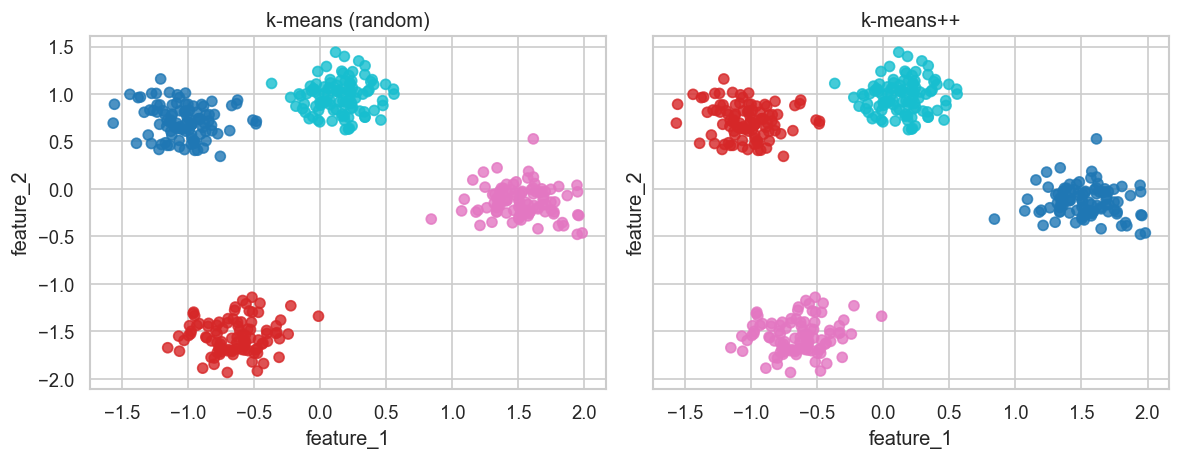

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

for ax, labels, title in [
    (axes[0], labels_random, "k-means (random)"),
    (axes[1], labels_pp, "k-means++"),
]:
    ax.scatter(
        X_scaled[:, 0],
        X_scaled[:, 1],
        c=labels,
        cmap="tab10",
        alpha=0.8,
    )
    ax.set_title(title)
    ax.set_xlabel("feature_1")
    ax.set_ylabel("feature_2")

plt.tight_layout()
plt.show()
